In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/shpva/OneDrive/Desktop/IndependentStudy_CIS5369/McCoy_Totals.csv',index_col='Date',parse_dates=True)
#df['Date'] = pd.to_datetime(df['Date'])
df1 = df.filter(['Date','MCCOY.ELEC.BTUS.DAY'])

In [3]:
df1.head()

,MCCOY.ELEC.BTUS.DAY
Date,
2021-10-01,9971163.0
2021-10-02,8757426.0
2021-10-03,9152674.0
2021-10-04,11600000.0
2021-10-05,11500000.0


<AxesSubplot:xlabel='Date'>

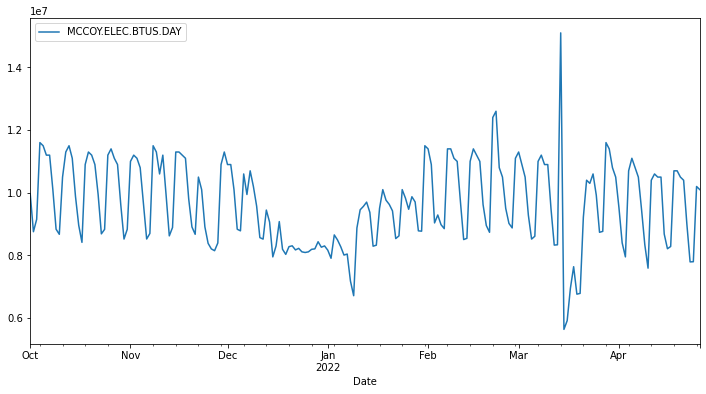

In [4]:
df1.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

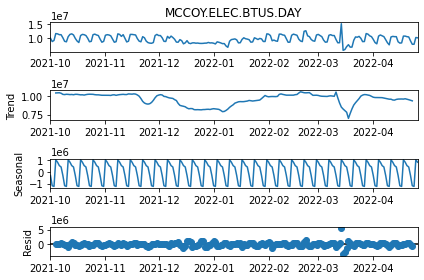

In [6]:
results = seasonal_decompose(df1['MCCOY.ELEC.BTUS.DAY'])
results.plot();

In [7]:
len(df1)

208

In [8]:
train = df1.iloc[:190]
test = df1.iloc[190:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df1.head(),df1.tail()

(            MCCOY.ELEC.BTUS.DAY
 Date                           
 2021-10-01            9971163.0
 2021-10-02            8757426.0
 2021-10-03            9152674.0
 2021-10-04           11600000.0
 2021-10-05           11500000.0,
             MCCOY.ELEC.BTUS.DAY
 Date                           
 2022-04-22            9002116.0
 2022-04-23            7795156.0
 2022-04-24            7800369.5
 2022-04-25           10200000.0
 2022-04-26           10100000.0)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.45768024],
       [0.32934051],
       [0.37113377],
       [0.62991236],
       [0.61933843],
       [0.58761664],
       [0.58761664],
       [0.47130338],
       [0.33786225],
       [0.32061945]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [63]:
# define generator
n_input = 14 #seasonality component
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [64]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.45768024 0.32934051 0.37113377 0.62991236 0.61933843 0.58761664
 0.58761664 0.47130338 0.33786225 0.32061945 0.51359911 0.59819057
 0.61933843 0.5770427 ]
Predict this y: 
 [[0.44827737]]


In [65]:
X.shape

(1, 14, 1)

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [67]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(generator,epochs=50)

Epoch 1/50
176/176 [==============================] - 3s 6ms/step - loss: 0.0255
Epoch 2/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0195
Epoch 3/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0193
Epoch 4/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0184
Epoch 5/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0186
Epoch 6/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0175
Epoch 7/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0162
Epoch 8/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0163
Epoch 9/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0154
Epoch 10/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0153
Epoch 11/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 12/50
176/176 [==============================] - 1s 5ms/step - loss: 0.0138
Epoch 13/50
176/176 [====

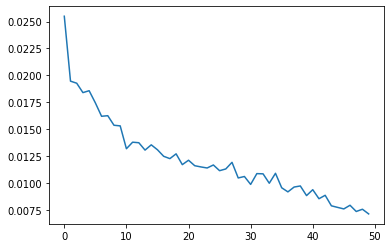

In [70]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [71]:
last_train_batch = scaled_train[-14:]

In [72]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [73]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 138ms/step


array([[0.31478572]], dtype=float32)

In [74]:
scaled_test[0]

array([0.28549491])

In [75]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [76]:
test_predictions

[array([0.31478572], dtype=float32),
 array([0.268451], dtype=float32),
 array([0.4575839], dtype=float32),
 array([0.5179446], dtype=float32),
 array([0.4815619], dtype=float32),
 array([0.4345274], dtype=float32),
 array([0.36874056], dtype=float32),
 array([0.29610518], dtype=float32),
 array([0.26592973], dtype=float32),
 array([0.3811688], dtype=float32),
 array([0.4692611], dtype=float32),
 array([0.44608593], dtype=float32),
 array([0.40999022], dtype=float32),
 array([0.35018125], dtype=float32),
 array([0.28551263], dtype=float32),
 array([0.2634352], dtype=float32),
 array([0.34612066], dtype=float32),
 array([0.42451686], dtype=float32)]

In [77]:
test.head()

,MCCOY.ELEC.BTUS.DAY,Predictions
Date,,
2022-04-09,8342768.5,8.691870e+06
2022-04-10,7594869.0,8.571252e+06
2022-04-11,10400000.0,1.078163e+07
2022-04-12,10600000.0,1.099752e+07
2022-04-13,10500000.0,1.073027e+07


In [78]:
true_predictions = scaler.inverse_transform(test_predictions)

In [79]:
test['Predictions'] = true_predictions

<ipython-input-79-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

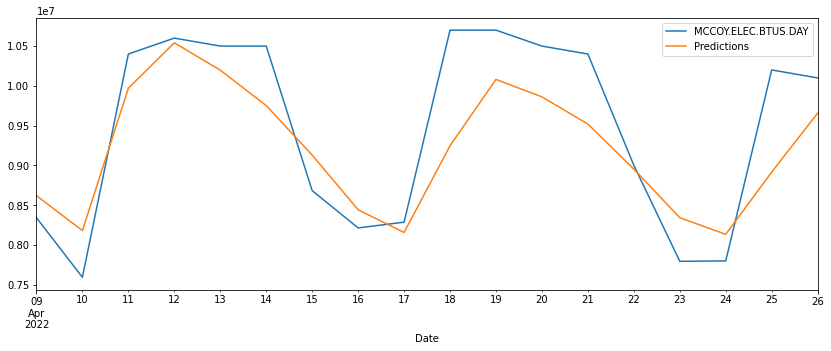

In [80]:
test.plot(figsize=(14,5))

In [81]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['MCCOY.ELEC.BTUS.DAY'],test['Predictions']))
print(rmse)

643821.8597000868


In [83]:
model.save('EnergyLSTM_model.h5')

In [ ]:
--------------------------------------------------------------------------------------------------------------